# PA001: Rossmann Sales Prediction


# Planejamento da solução (IOT)

# Input - Entrada

# O problema de negócio

### Gerar previsões de faturamento para cada uma das lojas para 6 semanas, pois este representa requisito de decisão de investimento para loja, justificando assim o investimento condicionado ao faturamento futuro.

# Output - Saída

### Previsões de faturamento diário para cada uma das lojas acompanhadas online

# Tasks - Processo


Rossmann_Sales_Analysis

Dirk Rossmann GmbH (usual: Rossmann) is one of the largest drug store chains in Europe with around 56,200 employees and more than 4000 stores across Europe.

The company was founded by Dirk Rossmann with its headquarters in Burgwedel near Hanover in Germany. The Rossmann family owns 60%, and the Hong Kong-based A.S. Watson Group 40% of the company.

The company logo consists of a red name and the symbol of a centaur integrated in the letter O: a mythical creature made of horse and man from Greek mythology, which symbolically stands for "Rossmann" (English: "Horse man").The company's own brands have a small centaur symbol above the name.

Since 2018, Rossmann has been publishing a sustainability report for the development of corporate climate protection activities.
References

"Europe: top personal care retailers' store numbers 2019". Statista. Retrieved 2020-12-07.

"Personal Care Retailers in Europe". www.retail-index.com. Retrieved 2020-12-07.

"Annual report 2019" (PDF).

"Dirk Rossmann". Forbes. Retrieved 9 June 2015.

"Deshalb hat Rossmann so ein ungewöhnliches Logo gewählt". Business Insider (in German). 2016-08-19. Retrieved 2020-12-07.

"Wusstest du es? Das ist das Geheimnis hinter dem Rossmann-Logo!". BRIGITTE (in German). Retrieved 2020-12-07.

"Markengeschichte". ROSSMANN Unternehmen. Retrieved 2020-12-07.

"Nachhaltig zum Erfolg | Markant Magazin". www.markant-magazin.com. Retrieved 2021-06-14.

"ROSSMANN-Nachhaltigkeitsbericht". ROSSMANN-Nachhaltigkeitsbericht. Retrieved 2021-06-14.

# Data extraction

## Files Description

* train.csv - historical data including Sales

* test.csv - historical data excluding Sales

* store.csv - supplemental information about the stores
* Data Fields Description

* Id - an Id that represents a (Store, Date) duple within the test set

* Store - a unique Id for each store

* Sales - the turnover for any given day (this is what you are predicting)

* Customers - the number of customers on a given day

* Open - an indicator for whether the store was open: 0 = closed, 1 = open

* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

* StoreType - differentiates between 4 different store models: a, b, c, d

* Assortment - describes an assortment level: a = basic, b = extra, c = extended

* CompetitionDistance - distance in meters to the nearest competitor store

* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

* Promo - indicates whether a store is running a promo on that day

* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# 0.0 Imports

In [1]:
import pandas  as  pd
import numpy   as  np
import seaborn as  sns
import inflection
import math


from IPython.core.display import HTML
from IPython.display      import Image

# Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

def check_dataframe( dataframe, sample_size = 3 ):
    '''
    Print number of NAs, percentage of NA to the given column,
    number of unique values, data types, dataframe shape and 
    return a random sample of dataframe'''
    
    # create dictionary with descriptive information
    dict_data = {'Num NAs':     dataframe.isna().sum(),
                 'Percent NAs': dataframe.isna().mean(),
                 'Num unique':  dataframe.nunique(),
                 'Data Type':   dataframe.dtypes }
  
    # print descriptive data
    print( pd.DataFrame( dict_data ), '\n' )
    # print dataframe shape
    print( f'Dataframe shape is {dataframe.shape}', '\n' )  
    
    
    return dataframe.sample( sample_size )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Loading Data

In [3]:
pwd

'/home/ehgeraldo/repos/Rossmann_Store_Sales/notebooks'

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.1 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1.1 Data dimensions

In [6]:
print( 'Number of Rows:    {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows:    1017209
Number of Columns: 18


## 1.1.2 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

In [9]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1.3 Data types

In [10]:
df1 = df1.copy()
check_dataframe( df1 ) 

                              Num NAs  Percent NAs  Num unique Data Type
store                               0     0.000000        1115     int64
day_of_week                         0     0.000000           7     int64
date                                0     0.000000         942    object
sales                               0     0.000000       21734     int64
customers                           0     0.000000        4086     int64
open                                0     0.000000           2     int64
promo                               0     0.000000           2     int64
state_holiday                       0     0.000000           4    object
school_holiday                      0     0.000000           2     int64
store_type                          0     0.000000           4    object
assortment                          0     0.000000           3    object
competition_distance             2642     0.002597         654   float64
competition_open_since_month   323348     0.317878 

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
788624,1105,4,2013-07-25,2611,351,1,0,0,1,c,c,330.0,11.0,2008.0,1,5.0,2013.0,"Feb,May,Aug,Nov"
928711,702,4,2013-03-21,4666,362,1,1,0,0,a,a,8550.0,9.0,2001.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
625256,527,3,2013-12-18,17984,1460,1,1,0,0,d,c,5830.0,4.0,2008.0,0,NaN,NaN,NaN


In [11]:
df1['date'] = pd.to_datetime( df1['date'] )

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.2 Fillout NAs

In [13]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [14]:
# I assumed a very large distance so that there was no competitor
# competition_distance

df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# I assumed that not that I was not competitive, but I took the month date of the last date when there was competition
# competition_open_since_month

df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )
    
# I assumed that not that I was not competitive, but I took the year date of the last date when there was competition
# competition_open_since_year  

df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )

# I assumed that not that I was not promo2, but I took the week date of the last date when there was competition
# promo2_since_week   

df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )                    

# I assumed that not that I was not promo2, but I took the year date of the last date when there was competition
# promo2_since_year

df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )                    

             
# promo_interval:

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )  

In [15]:
df1 = df1.copy()
check_dataframe( df1 ) 

                              Num NAs  Percent NAs  Num unique       Data Type
store                               0          0.0        1115           int64
day_of_week                         0          0.0           7           int64
date                                0          0.0         942  datetime64[ns]
sales                               0          0.0       21734           int64
customers                           0          0.0        4086           int64
open                                0          0.0           2           int64
promo                               0          0.0           2           int64
state_holiday                       0          0.0           4          object
school_holiday                      0          0.0           2           int64
store_type                          0          0.0           4          object
assortment                          0          0.0           3          object
competition_distance                0          0.0  

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
694362,503,4,2013-10-17,5252,394,1,0,0,0,d,c,13080.0,9.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Oct,1
733634,750,4,2013-09-12,4810,361,1,1,0,0,d,a,8670.0,2.0,2002.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Sep,0
72315,956,4,2015-05-28,3176,413,1,0,0,0,a,a,2330.0,10.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov",May,1


# 1.3 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# Change float to int thouse attributes

# competition_open_since_month           float64
# competition_open_since_year            float64
# promo2_since_week                      float64
# promo2_since_year                      float64

In [18]:
df1[ 'competition_open_since_month' ] = df1[ 'competition_open_since_month' ].astype(int)

df1[ 'competition_open_since_year' ]  = df1[ 'competition_open_since_year' ].astype(int)

df1[ 'promo2_since_week' ]            = df1[ 'promo2_since_week'].astype(int)

df1[ 'promo2_since_year' ]            = df1[ 'promo2_since_year' ].astype(int)

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.4 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

## Numerical Attributes

In [21]:
# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [ d2,d3,d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Count'>

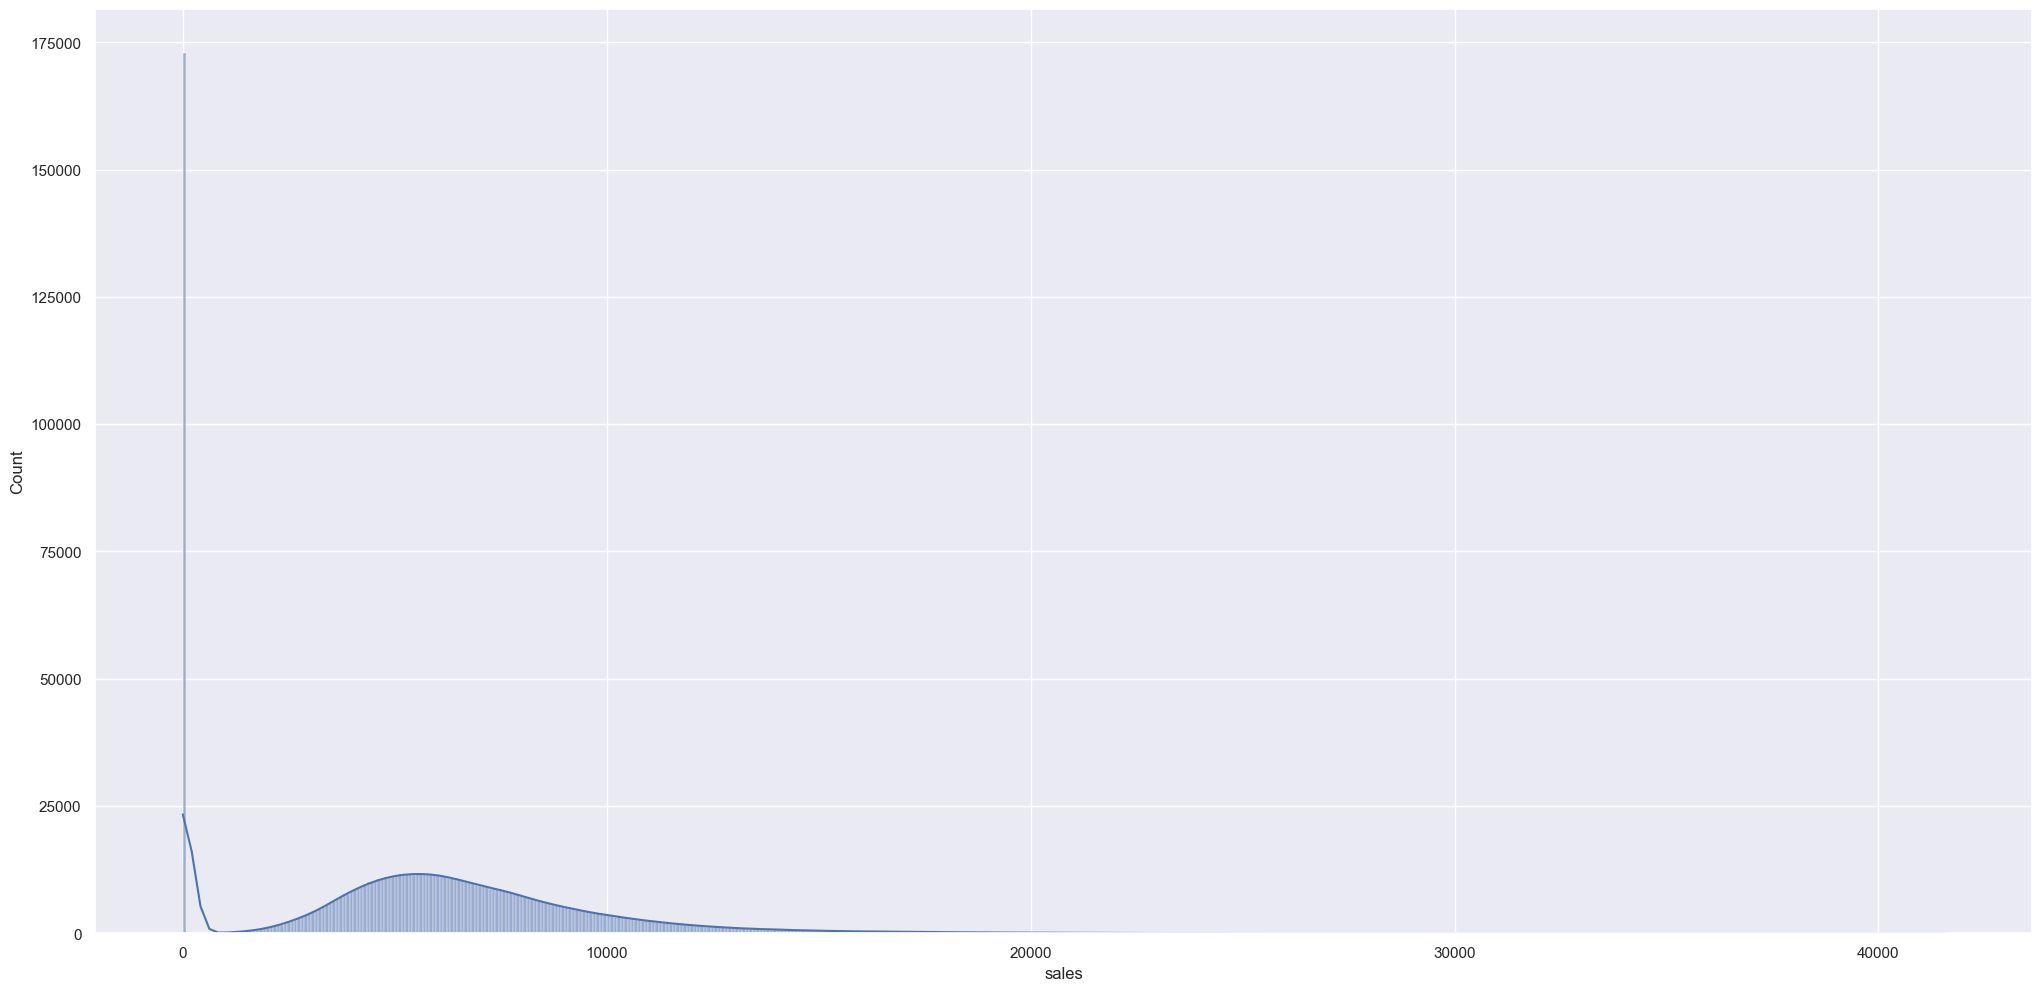

In [22]:
# min = 0, max = 7388.0, range = 41551, mean = 5773, std = 3849, skew = 0,64, kurtosis = 1,77

sns.histplot( df1['sales'], kde=True )

<AxesSubplot:xlabel='customers', ylabel='Count'>

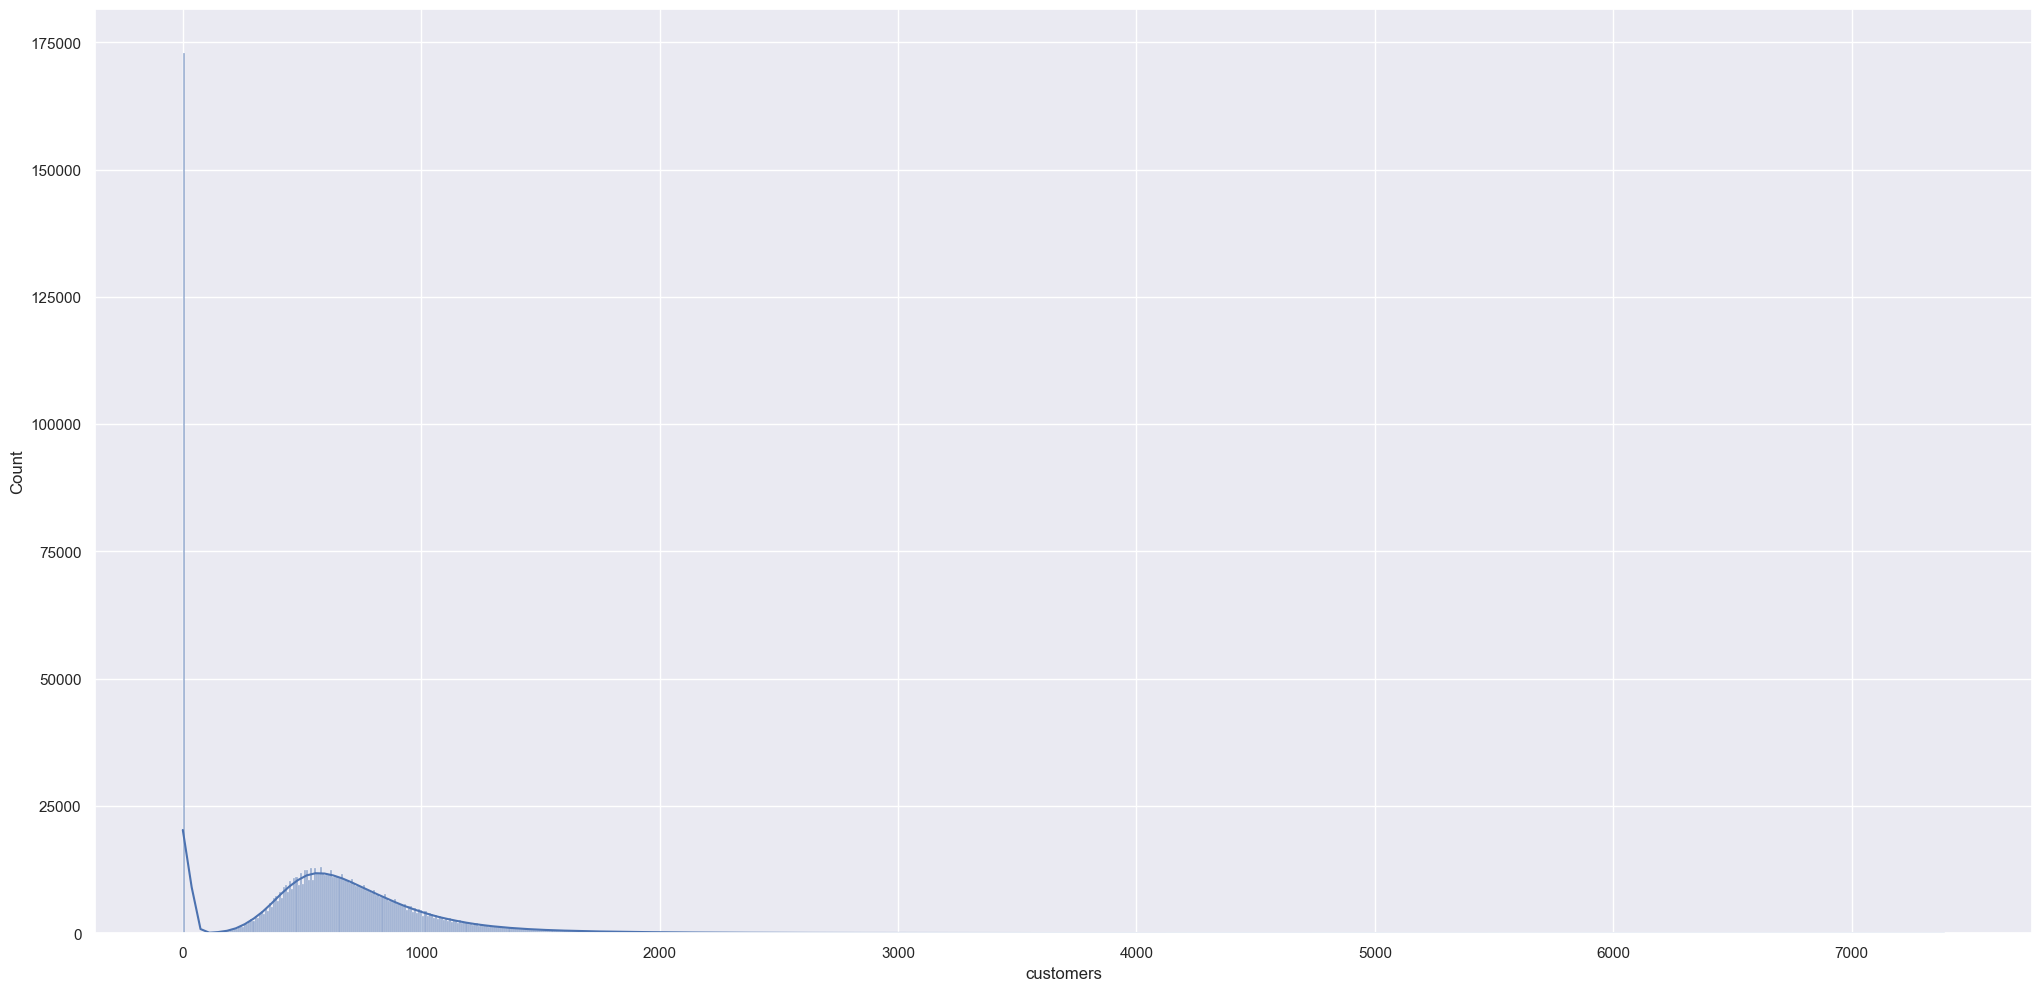

In [23]:
# min = 0, max = 7388.0, range = 7388.0, mean = 633, std = 464, skew = 1,59, kurtosis = 7,09
sns.histplot( df1['customers'], kde=True )

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

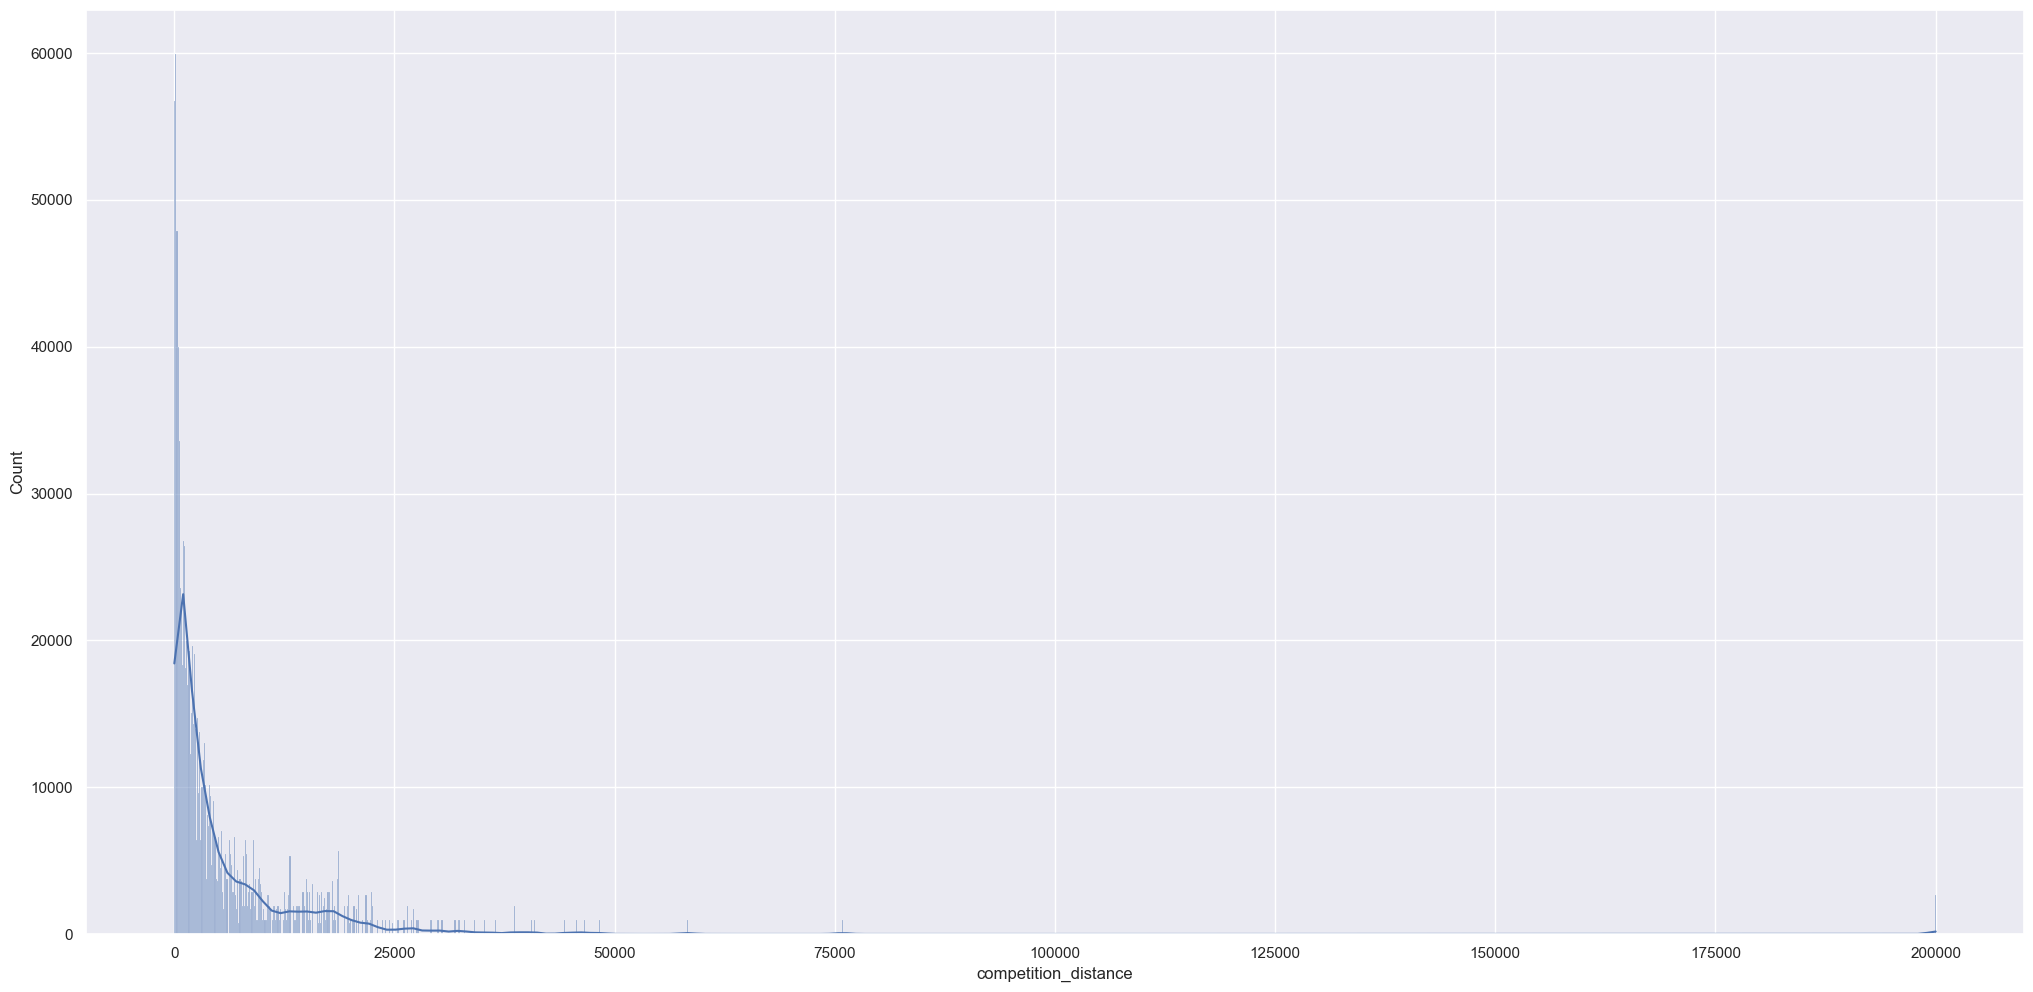

In [24]:
# min = 0, max = 200000.0, range = 200000.0, mean = 5935, std = 12547, skew = 10,24, kurtosis = 147,79
sns.histplot( df1['competition_distance'], kde=True )

## 1.4.1 Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

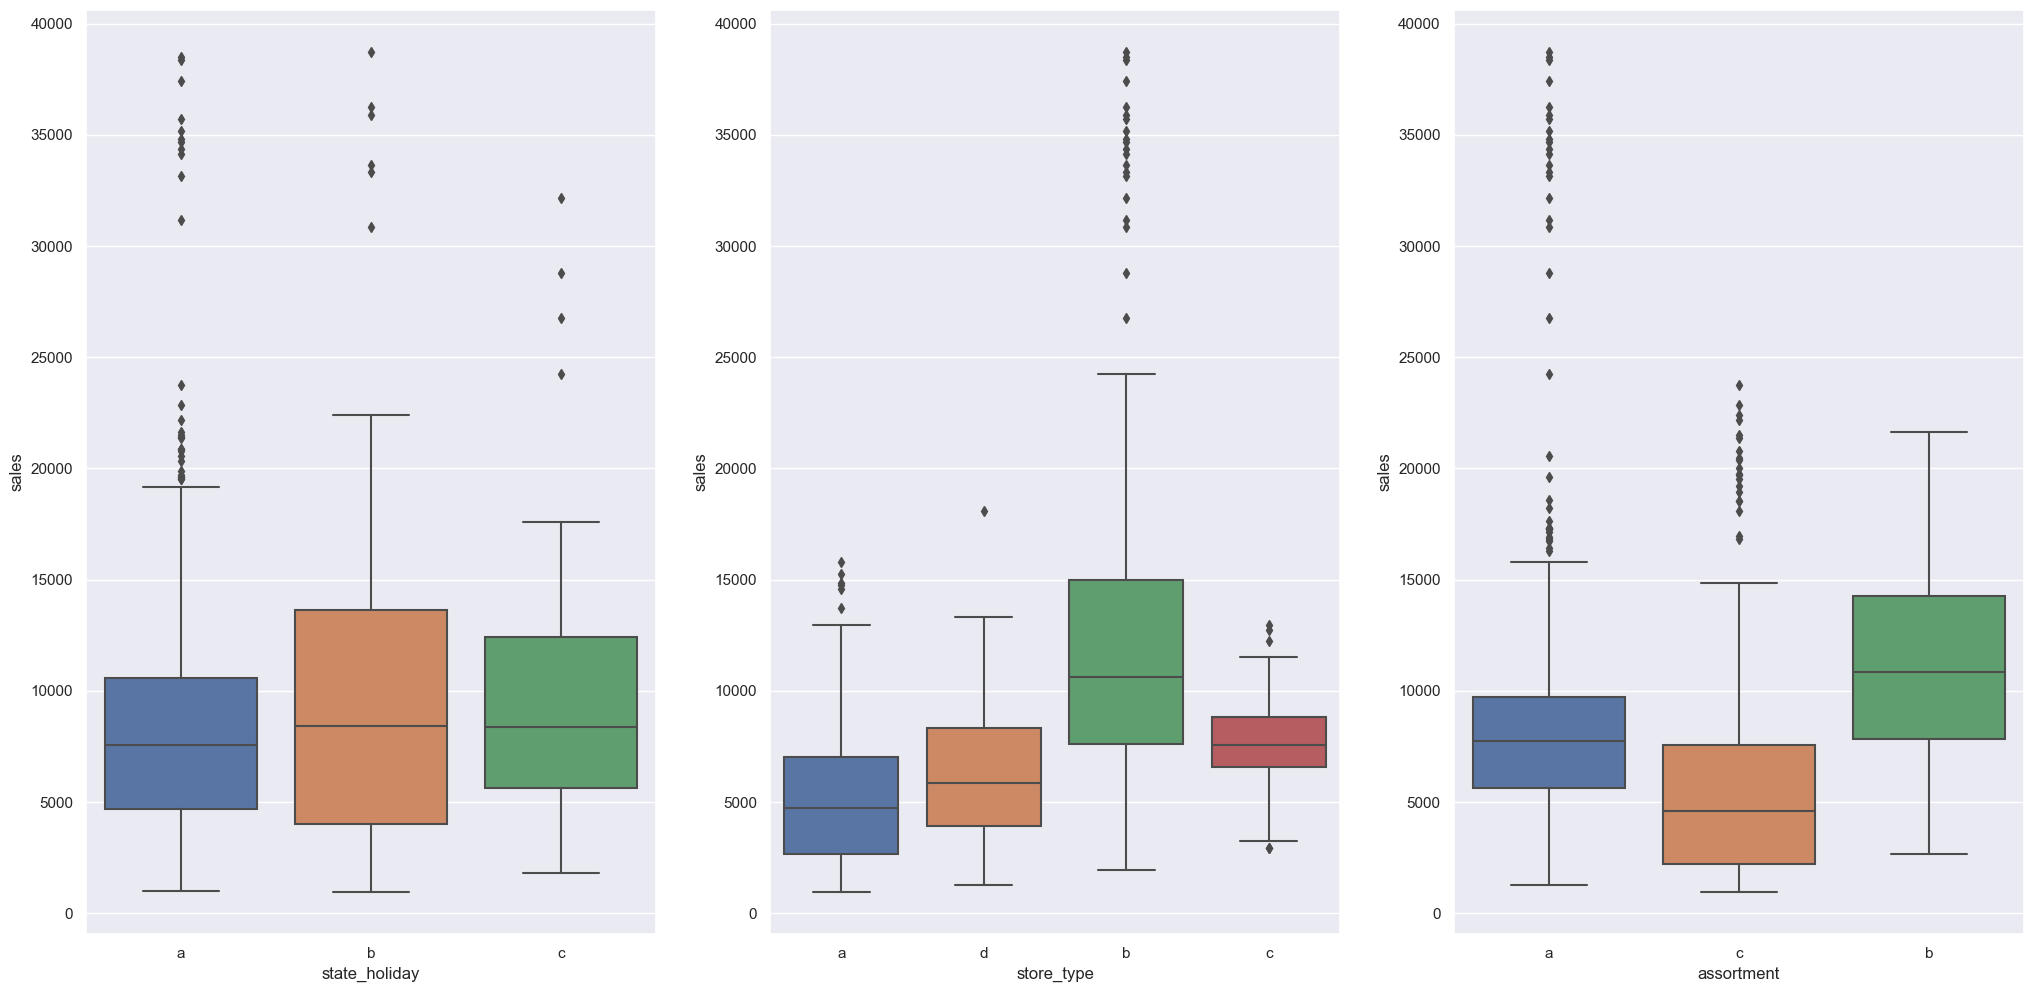

In [26]:
aux = df1[( df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1 )
sns.boxplot(x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2 )
sns.boxplot(x='store_type',    y='sales', data=aux )

plt.subplot(1, 3, 3 )
sns.boxplot(x='assortment',    y='sales', data=aux )

# 2.0 Hypoteses map

In [42]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

### 2.1.1 Hipóteses para fator Loja correlacionados com fator venda

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas de maior porte deveriam vender mais.

**4.** Lojas de menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hipóteses para fator Produto correlacionados com fator venda

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem podutos com menores preços deveriam vender mais. 

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

### 2.1.3 Hipóteses para fator Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao londo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares.



In [40]:
cd Rossmann_Store_Sales

/home/ehgeraldo/repos/Rossmann_Store_Sales


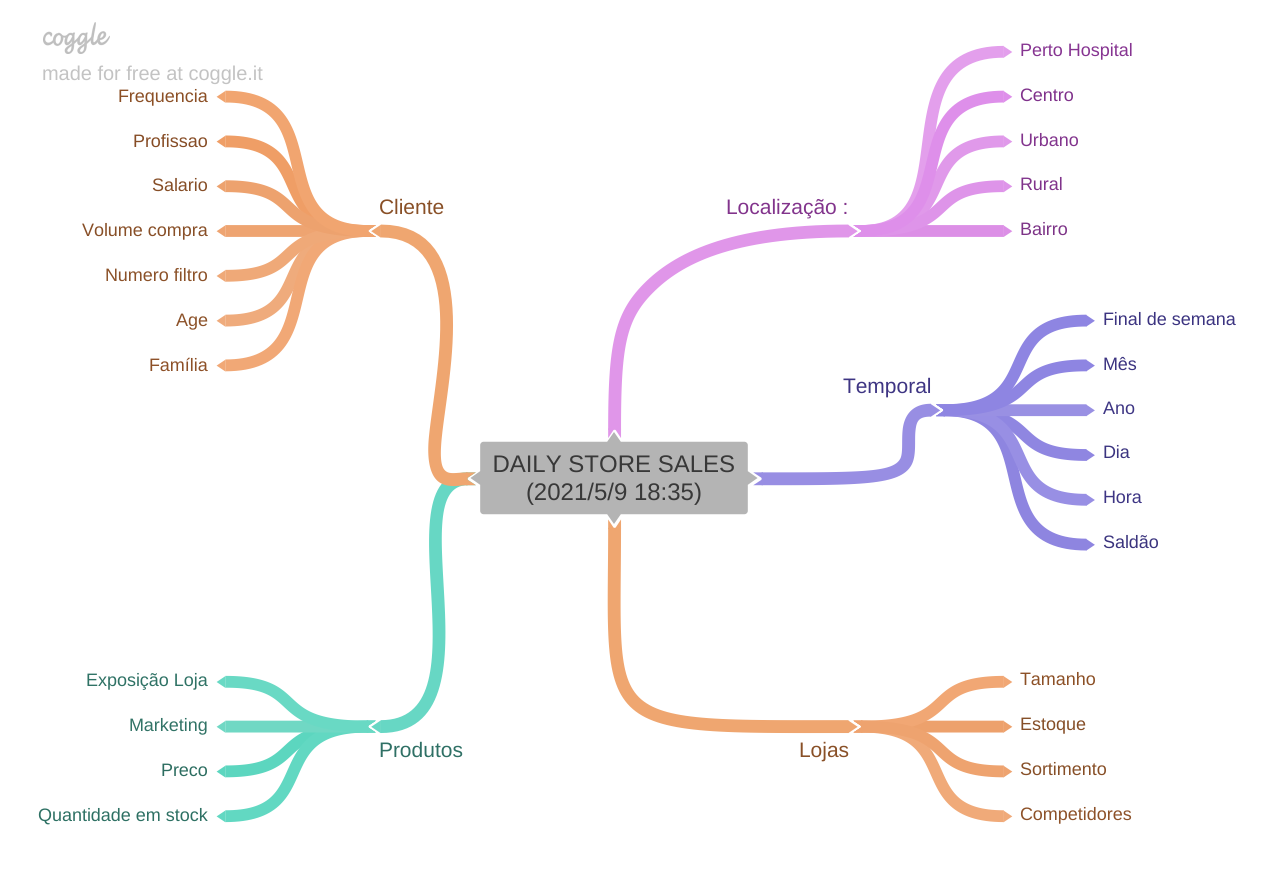

In [41]:
Image( 'image/daily_store_map_image.png' )

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

**5.** Lojas que tem podutos com menores preços deveriam vender mais. 

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais

**7.** Lojas deveriam vender mais ao londo dos anos

**8.** Lojas deveriam vender mais no segundo semestre do ano

**9.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**10.** Lojas deveriam vender menos aos finais de semana

**11.** Lojas deveriam vender menos durante os feriados escolares.



### 2.1.2 Hipóteses para fator Produto correlacionados com fator venda

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem podutos com menores preços deveriam vender mais. 

**4.** Lojas que mantém promoções por maiores períodos deveriam vender mais.

### 2.1.3 Hipóteses para fator Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao londo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depoois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares.

# 3.0 Feature engineering

In [43]:
df3 = df2.copy()

## 3.1 Variable filter application

In [ ]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Columns filter application

In [ ]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [44]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )

df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo since:
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )

df3['promo_since'] = df3['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment:
# a = basic, b = extra, c = extendend

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extendend' )

# state holiday:
# a = public holiday, b = easter holiday, c = christmas 

df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_5831/3267365088.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['week_of_year'] = df3['date'].dt.weekofyear


In [45]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4.0 EDA - Exploration Data Analysis

In [46]:
df4 = df3.copy()

 ## 4.1 Univariate Analysis

 ### 4.1.1 Response Variable 

/tmp/ipykernel_5831/3300234349.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'] )


<AxesSubplot:xlabel='sales', ylabel='Density'>

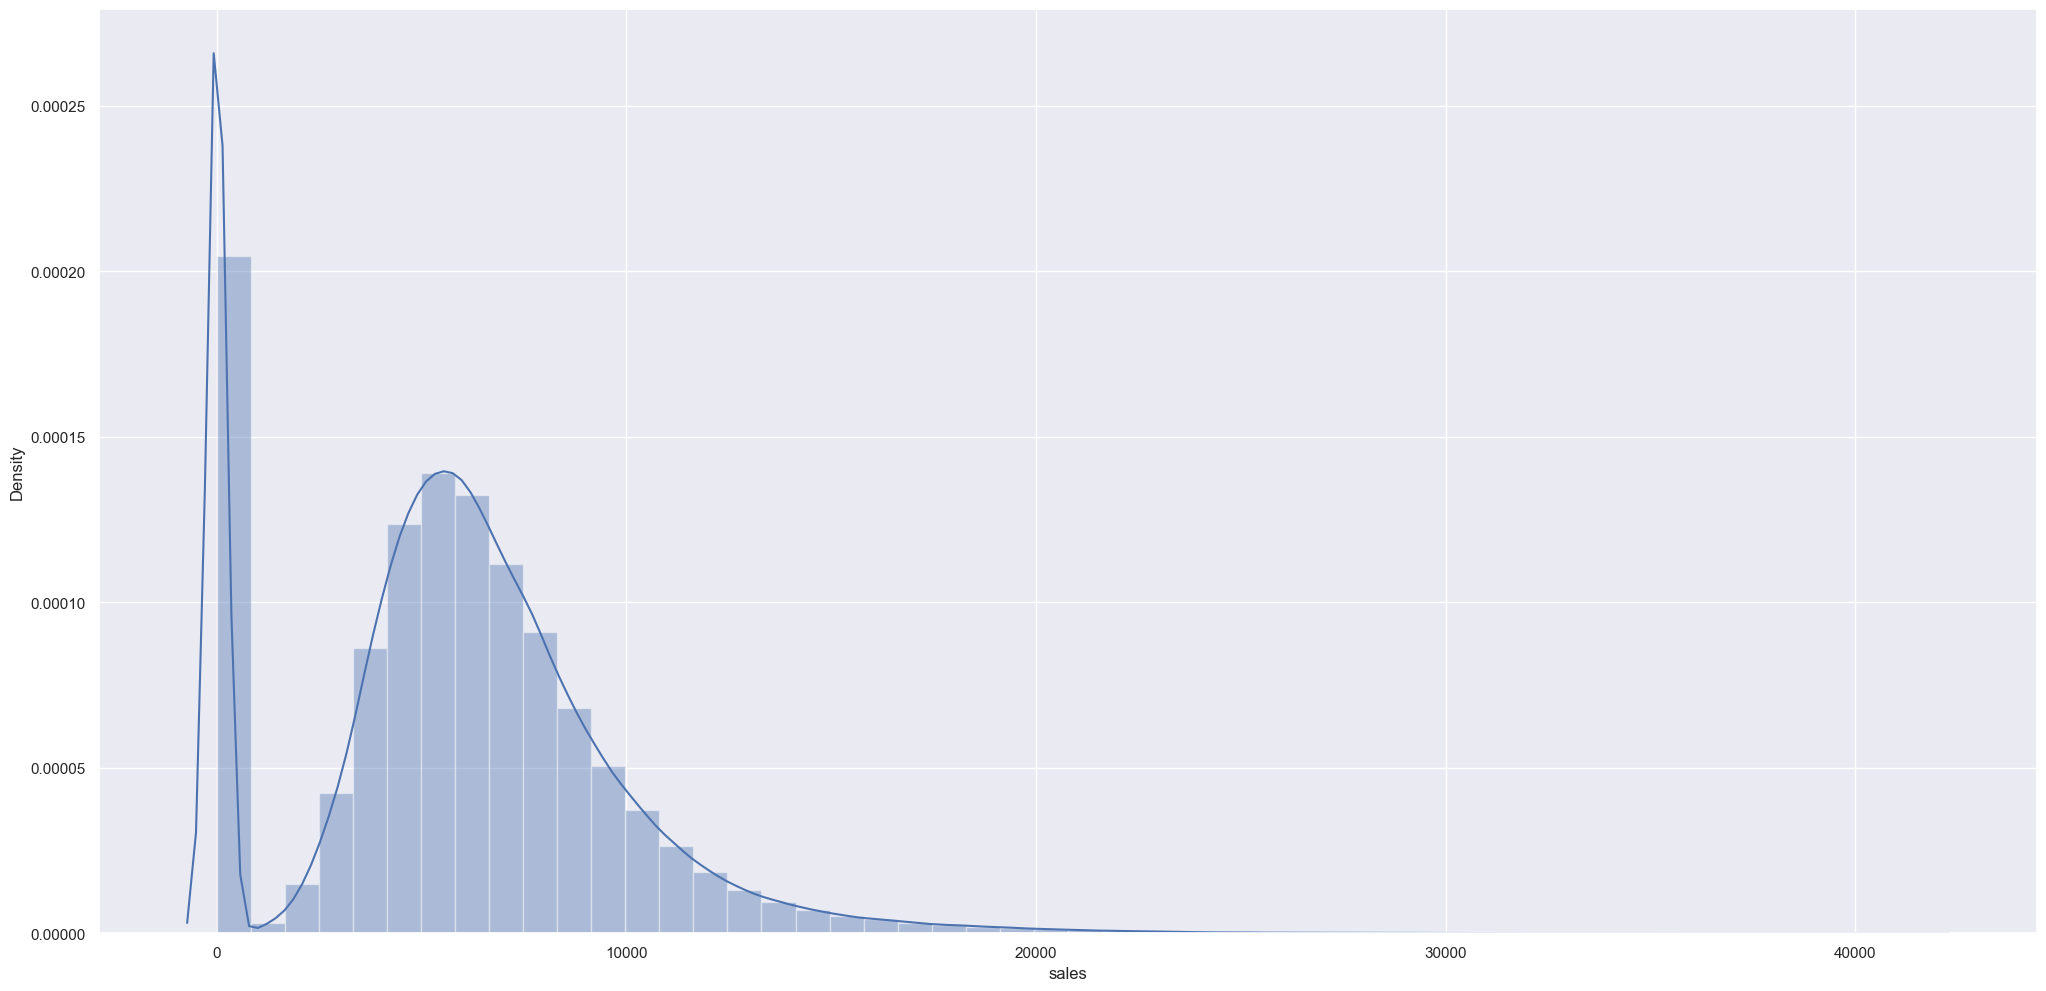

In [47]:
sns.distplot( df4['sales'] )

/tmp/ipykernel_5831/3854455431.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( np.log1p( df4['sales'] ) )


<AxesSubplot:xlabel='sales', ylabel='Density'>

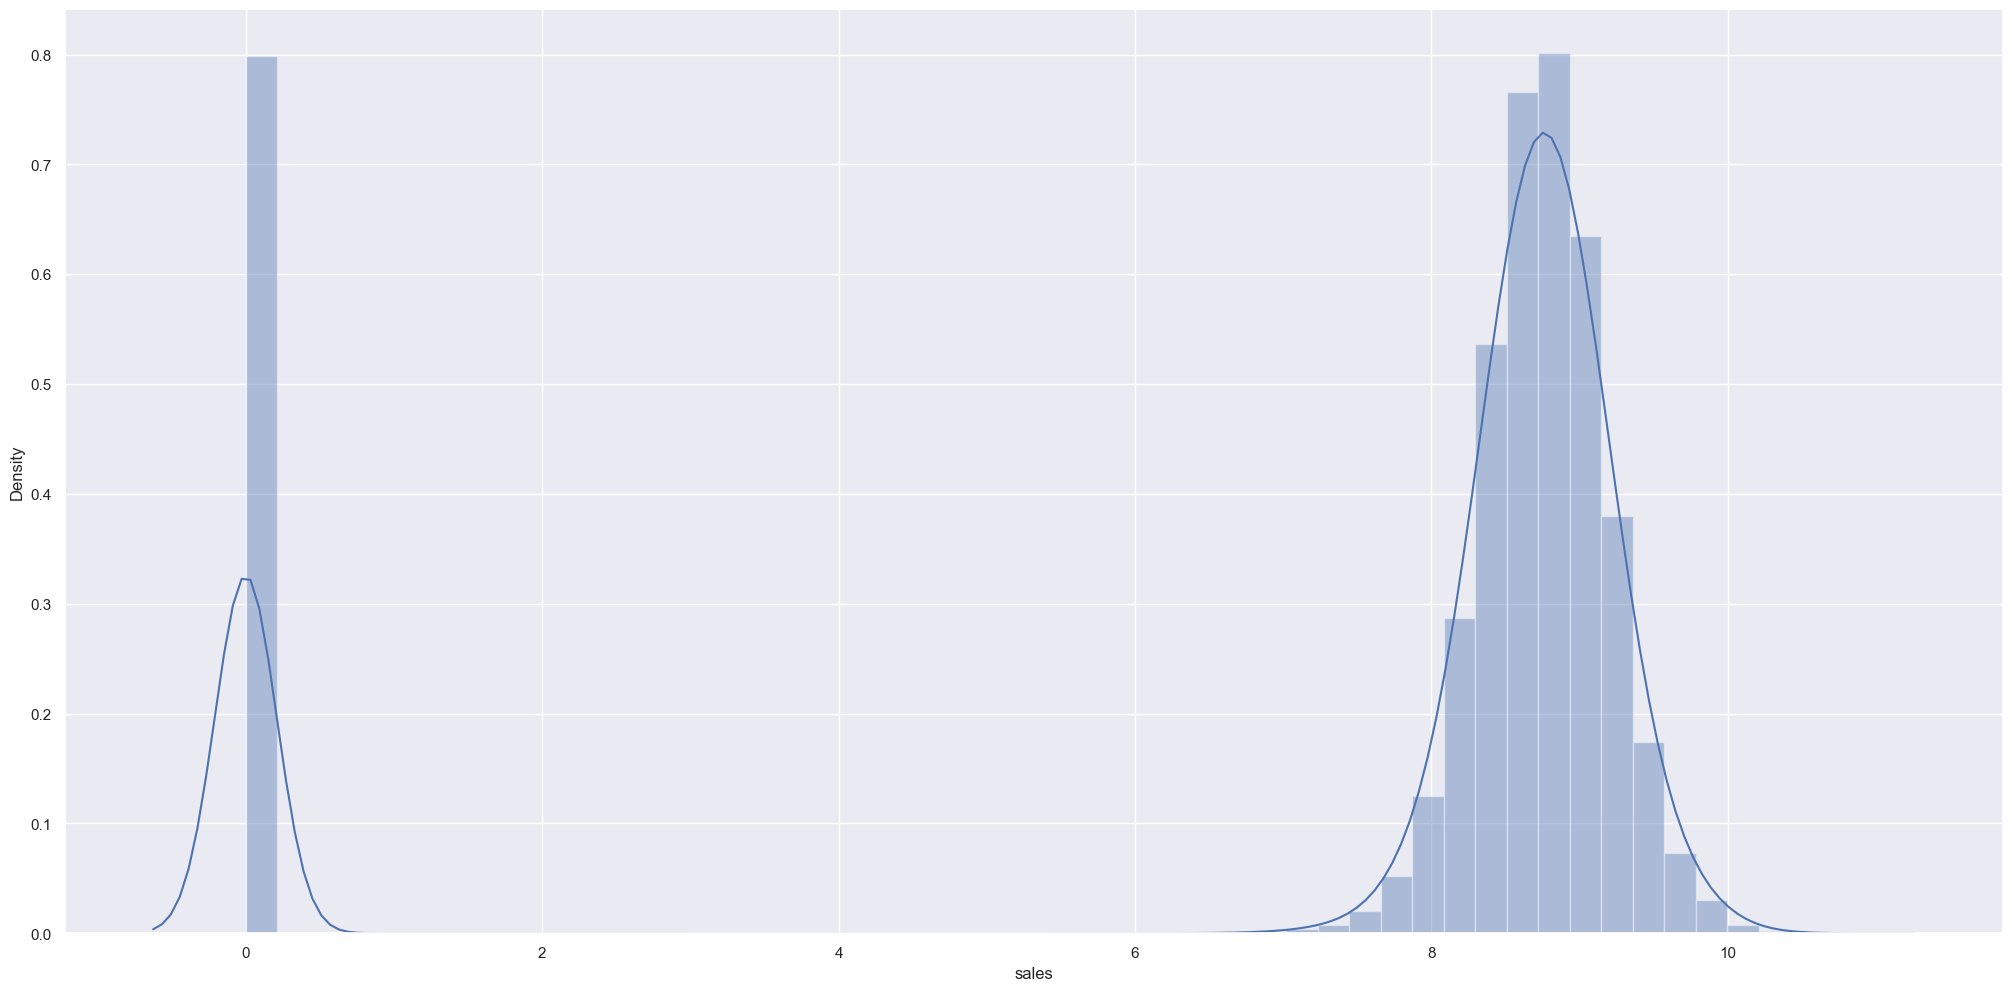

In [53]:
# log1p to response variable

sns.distplot( np.log1p( df4['sales'] ) )

 ## 4.1.2 Numerical Variable

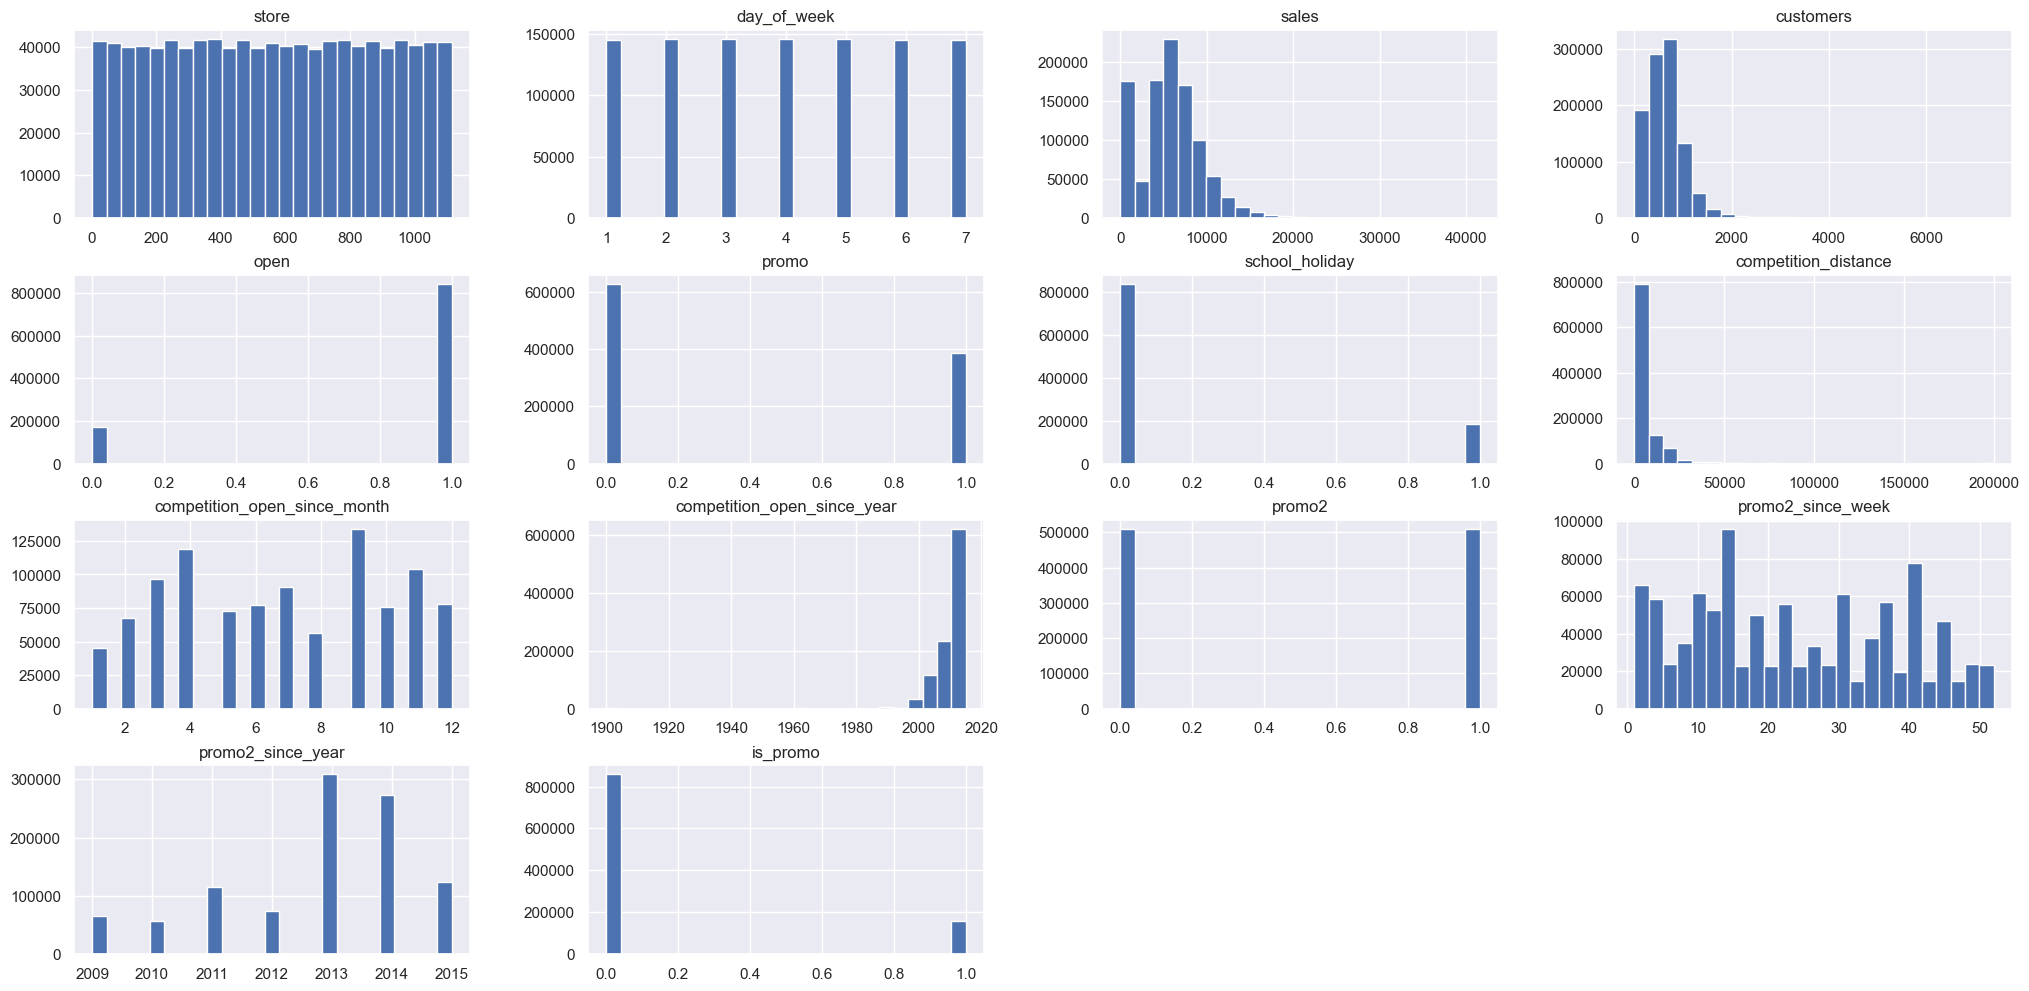

In [56]:
num_attributes.hist( bins=25 );

 sales -> skew neg (0 - 20000)
 
 customers -> skew neg (0 -2000)
 
 competition_open_since_year ->  skew neg (2000 2020)
 
 promo2_since_year -> [2013(max), 2014, 2015(min)]

 ## 4.1.3 Categorical Variable

In [57]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [58]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63555     public_holiday
129340    easter_holiday
241055         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

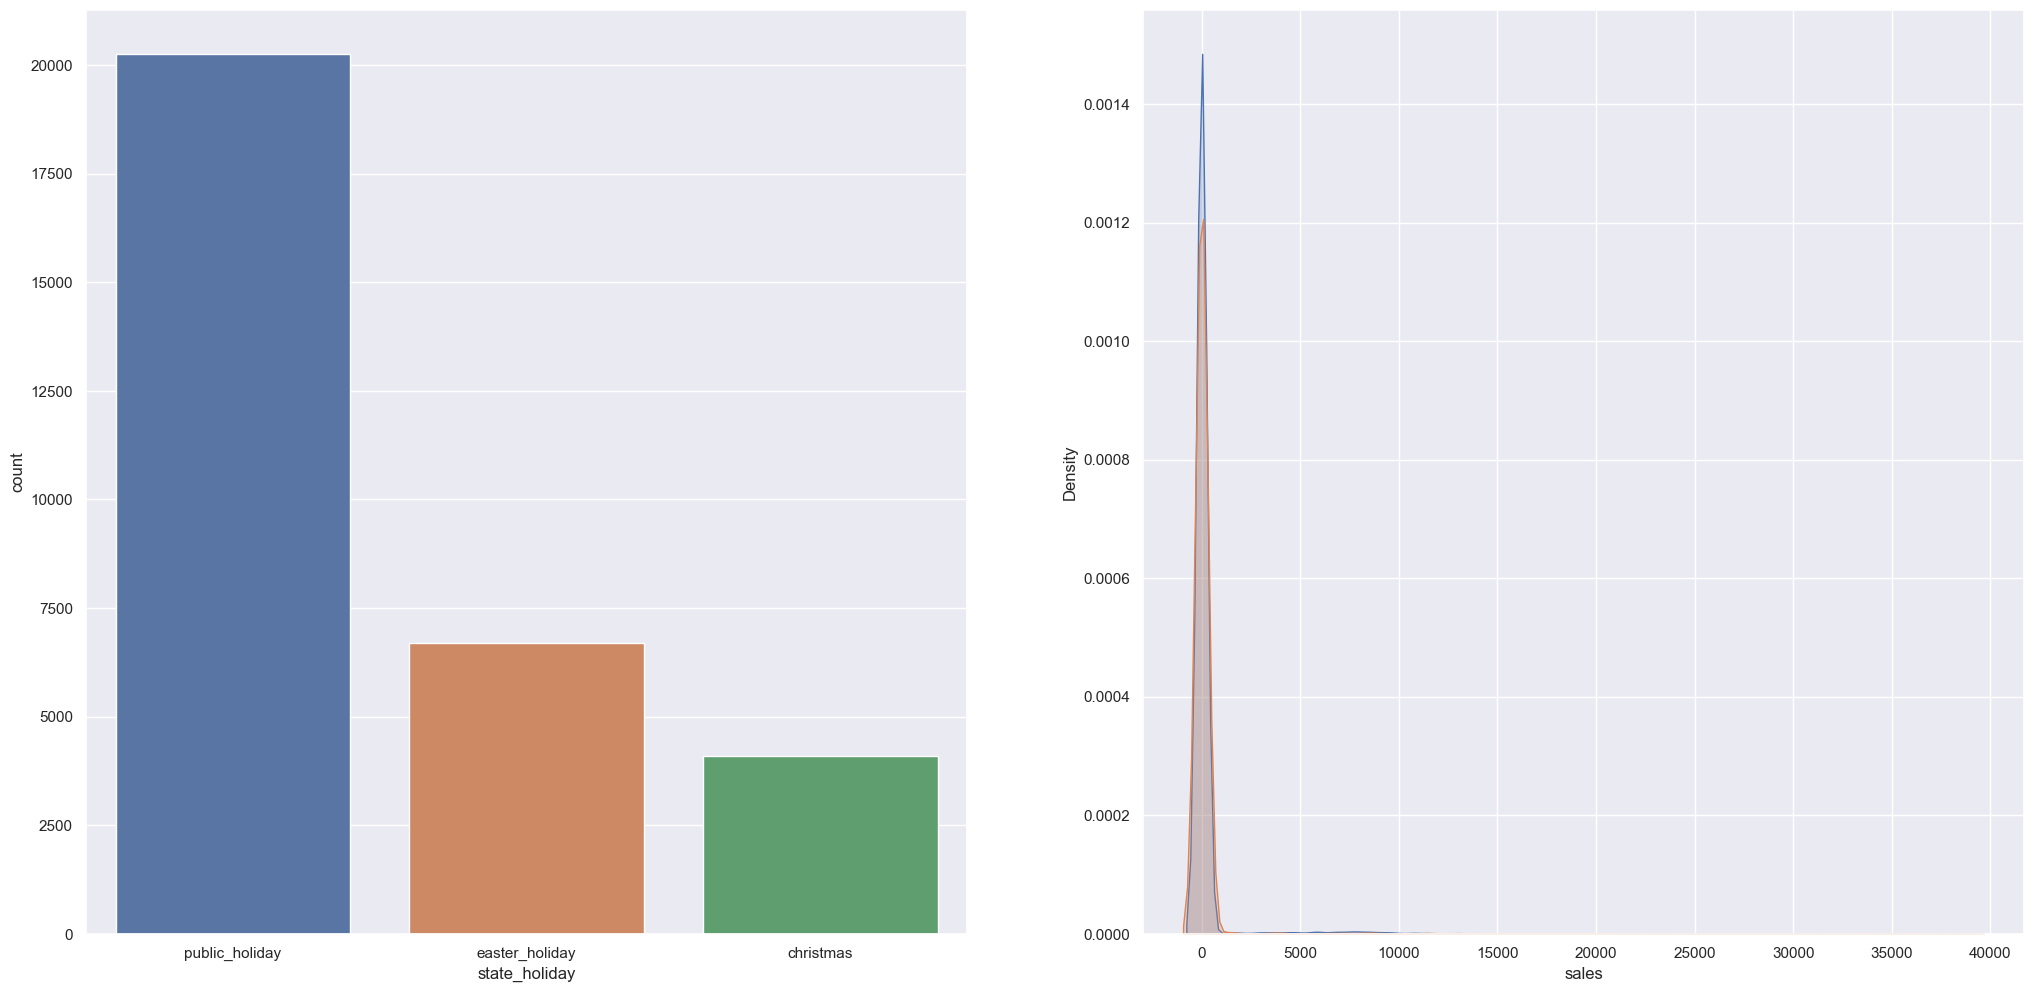

In [74]:
# state_holiday

# regular_day filter to clean graphic
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]

plt.subplot( 1, 2, 1 )
sns.countplot( data = a, x ='state_holiday' )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',    fill=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'chrstimas_holiday']['sales'], label='chrstimas_holiday', fill=True )

<AxesSubplot:xlabel='sales', ylabel='Density'>

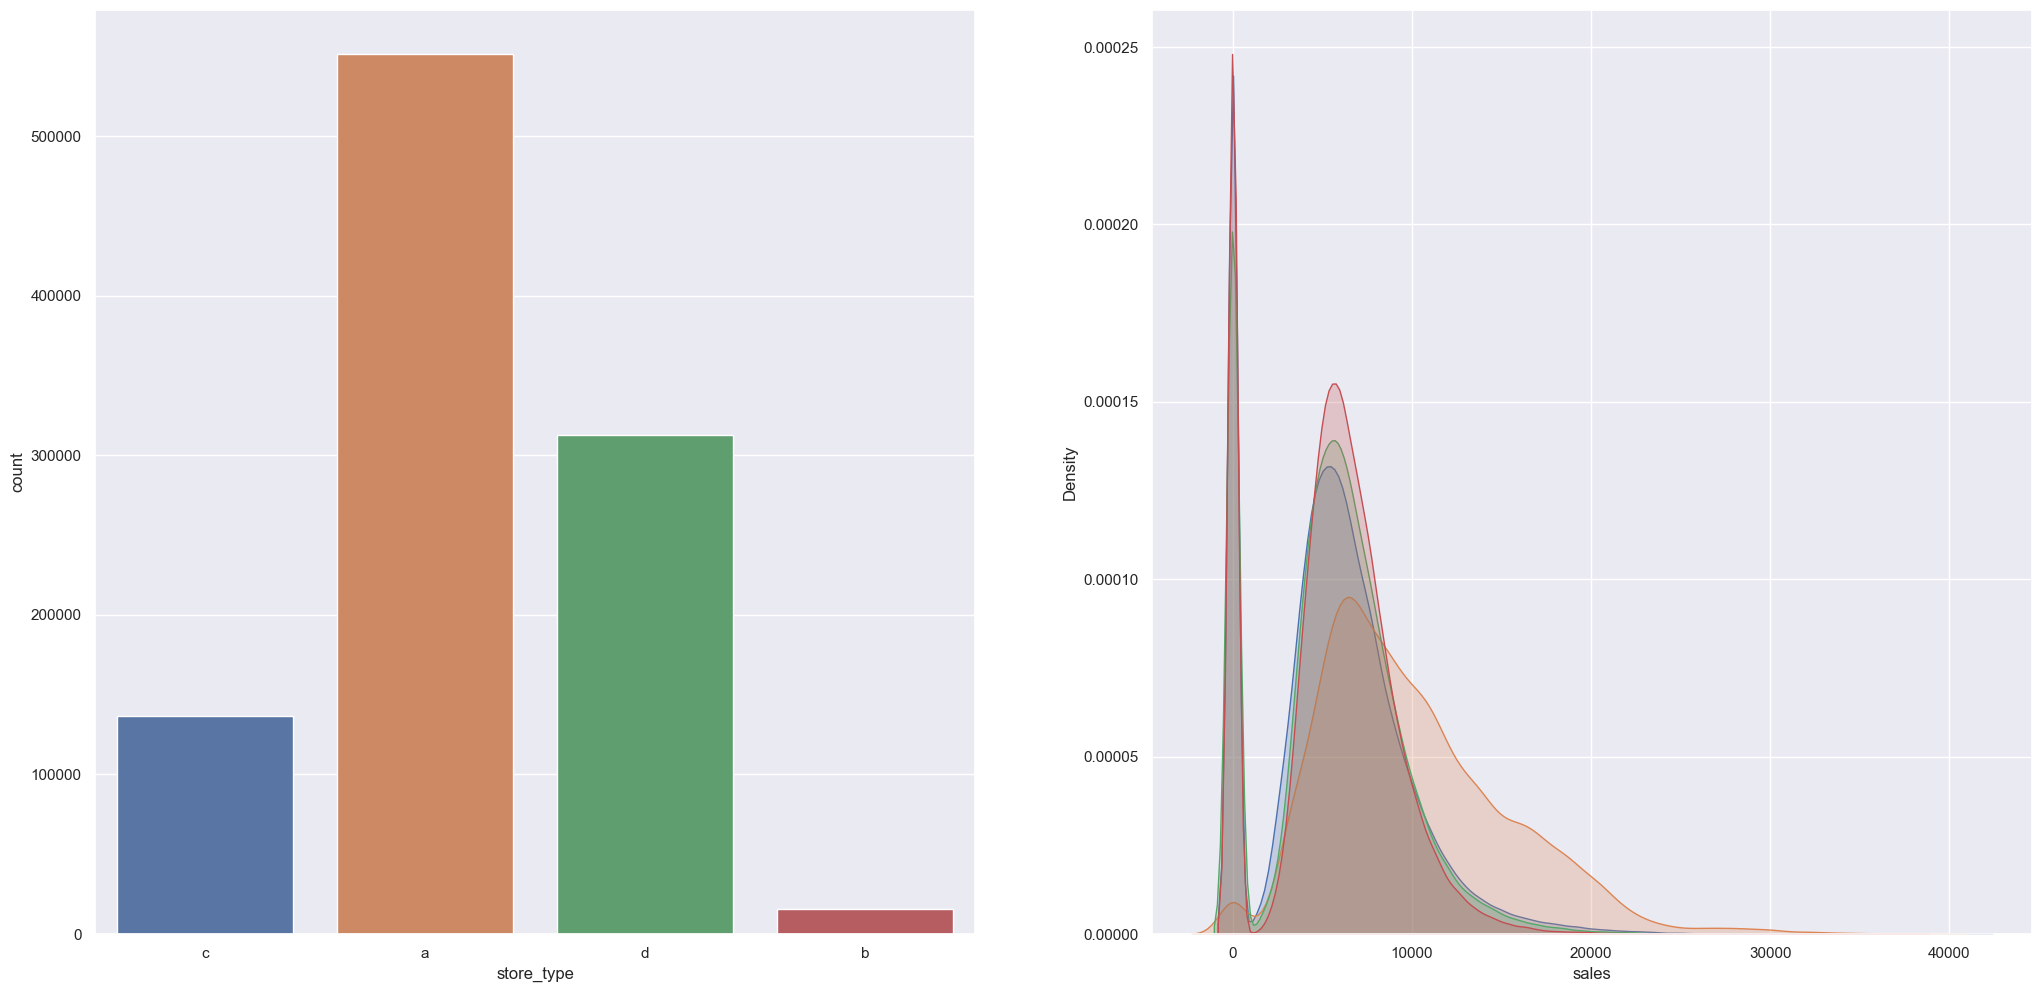

In [76]:
# store_type
plt.subplot( 1, 2, 1 )
sns.countplot( data = df4, x ='store_type' )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c',fill=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d',fill=True )

<AxesSubplot:xlabel='sales', ylabel='Density'>

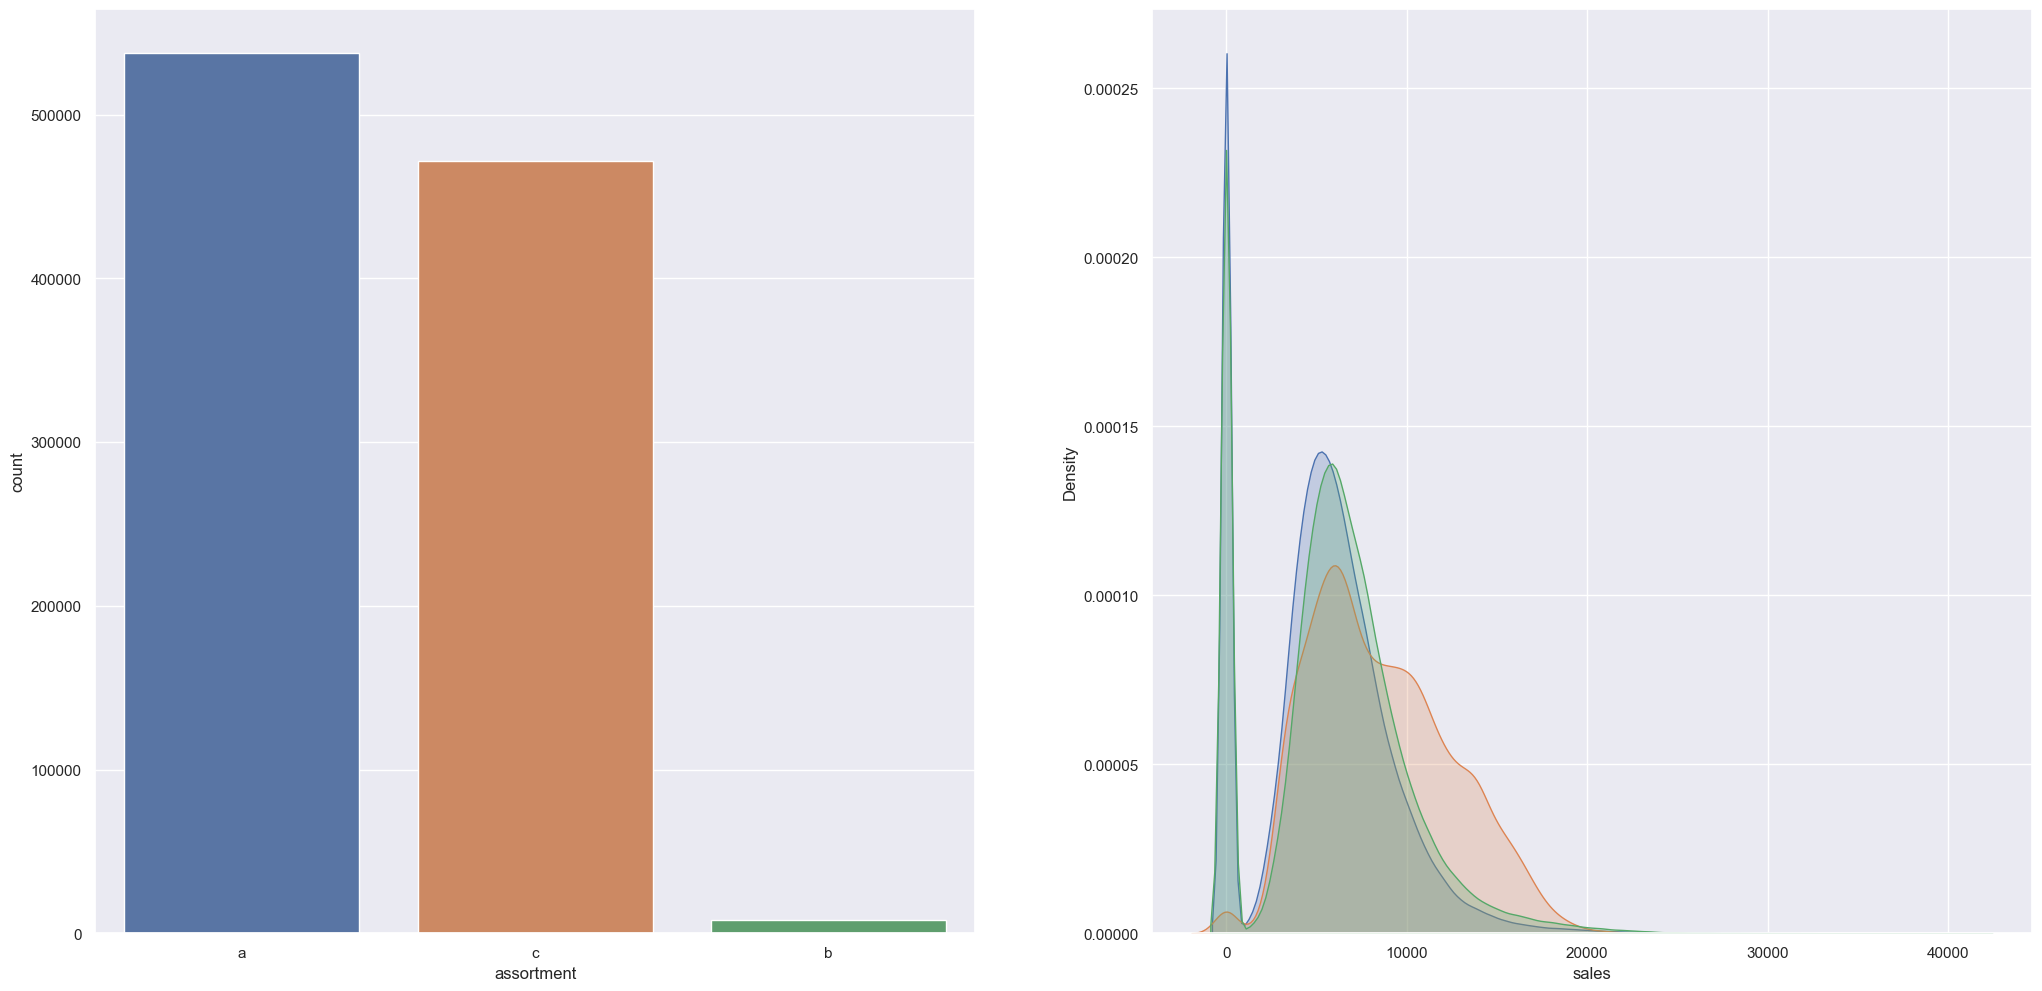

In [71]:
# assortment
plt.subplot( 1, 2, 1 )
sns.countplot( data = df4, x ='assortment' )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[ df4['assortment'] == 'a']['sales'], label='extended',fill=True )
sns.kdeplot( df4[ df4['assortment'] == 'b']['sales'], label='basic',fill=True )
sns.kdeplot( df4[ df4['assortment'] == 'c']['sales'], label='extra',fill=True )

 ## 4.2 Bivariate Analysis

In [ ]:
 ### 4.1.1 Response Variable

 ## 4.3 Multivariate Analysis